<a href="https://colab.research.google.com/github/bafanaS/dim-reduction-with-cnn-lstm/blob/main/Final_Exploratory_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and PreProcessing

In [28]:
# Import numpy and matplotlib style, credits to the original Miller 2010 dataset
import numpy as np
import pandas as pd

from matplotlib import rcParams # rcParams is a file that specifies Matplotlib style defaults
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] = 15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [29]:
# Import the dataset
import os, requests

fname = 'motor_imagery.npz'
url = "https://osf.io/ksqv8/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("!!! Failed to download data !!!")
  else:
    if r.status_code != requests.codes.ok:
      print("!!! Failed to download data !!!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)

alldat = np.load(fname, allow_pickle=True)['dat']

In [30]:
person = 0

In [31]:
from scipy import signal

# Data Preprocessing Functions
def pad_array(array, max_size):
    return np.pad(array, ((0, 0), (0, 0), (0, max_size - array.shape[2])), mode='constant', constant_values=np.nan)

def prepare_voltage_data(alldat, movement_type):
    num_dicts = alldat.shape[0]
    max_size = max(alldat[i][movement_type]['V'].shape[1] for i in range(num_dicts))
    arr_new = np.empty((len(alldat), 2, 30, 2000, max_size))

    for i in range(num_dicts):
        dat1 = alldat[i][movement_type]
        V = dat1['V'].astype('float32')
        nt, nchan = V.shape
        nstim = len(dat1['t_on'])
        trange = np.arange(0, 2000)
        ts = dat1['t_on'][:, np.newaxis] + trange
        V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))
        V_tongue = (V_epochs[dat1['stim_id'] == 11])
        V_hand = (V_epochs[dat1['stim_id'] == 12])
        arr_new[i][0] = pad_array(V_tongue, max_size)
        arr_new[i][1] = pad_array(V_hand, max_size)

    return arr_new

# Statistical Analysis Functions
def calculate_metrics(data):
    metrics = {
        'count': np.count_nonzero(~np.isnan(data)),
        'mean': np.nanmean(data),
        'std': np.nanstd(data),
        'max': np.nanmax(data),
        'min': np.nanmin(data),
        'median': np.nanmedian(data),
        '25th %tile': np.nanpercentile(data, 25),
        '50th %tile': np.nanpercentile(data, 50),
        '75th %tile': np.nanpercentile(data, 75)
    }
    return metrics

def bootstrap_sampling(data, sample_size, num_samples):
    bootstrap_samples = []
    means = []
    for _ in range(num_samples):
        indices = np.random.choice(np.arange(data.shape[0]), size=sample_size, replace=True)
        bootstrap_sample = data[indices]
        means.append(np.nanmean(bootstrap_sample))
    return np.array(means)



In [32]:
real_data = prepare_voltage_data(alldat, 0)
imag_data = prepare_voltage_data(alldat, 1)

real_reshaped = real_data.swapaxes(3, 4).reshape(2 * 7 * 30 * 64, 2000)
imag_reshaped = imag_data.swapaxes(3, 4).reshape(2 * 7 * 30 * 64, 2000)

num_samples = 500
sample_size = 1000

real_bootstrap_samples = bootstrap_sampling(real_reshaped, sample_size, num_samples)
real_metrics = calculate_metrics(real_bootstrap_samples)

imag_bootstrap_samples = bootstrap_sampling(imag_reshaped, sample_size, num_samples)
imag_metrics = calculate_metrics(imag_bootstrap_samples)

for r in imag_metrics:
    print(f"{r}: REAL - {real_metrics[r]}, IMAG - {imag_metrics[r]}")

count: REAL - 500, IMAG - 500
mean: REAL - 0.02648411068064088, IMAG - 0.011463907726783195
std: REAL - 0.010263233290306465, IMAG - 0.009797164347755006
max: REAL - 0.05933933924830147, IMAG - 0.04114790457978691
min: REAL - -0.0022639318923650485, IMAG - -0.018767942056311264
median: REAL - 0.0265940484639427, IMAG - 0.011597747147853839
25th %tile: REAL - 0.019875312628642637, IMAG - 0.005007859205600661
50th %tile: REAL - 0.0265940484639427, IMAG - 0.011597747147853839
75th %tile: REAL - 0.03298943445127086, IMAG - 0.018371519500344415


# Fourier Analysis

In [33]:
def getHandTongue(person:dict) -> tuple:


  dat1 = person
  V = dat1['V'].astype('float32')

  nt, nchan = V.shape
  nstim = len(dat1['t_on'])
  trange = np.arange(0, 2000)
  ts = dat1['t_on'][:, np.newaxis] + trange
  V_epochs = np.reshape(V[ts, :], (nstim, 2000, nchan))
  V_tongue = (V_epochs[dat1['stim_id'] == 11]).mean(0)
  V_hand = (V_epochs[dat1['stim_id'] == 12]).mean(0)

  return V_tongue, V_hand

In [35]:
# RUN THIS VERSION TO TAKE ALL DATA

from numpy.ma.core import outer
import numpy as np

# Get the number of dictionaries in the 'alldat' array
num_dicts = alldat.shape[0]

rtongueset, rhandset, itongueset, ihandset = ([], [], [], [])

max_size_r = max(alldat[i][0]['V'].shape[1] for i in range(num_dicts))
max_size_i = max(alldat[i][1]['V'].shape[1] for i in range(num_dicts))

# Iterate over each dictionary in 'alldat'
for i in range(num_dicts):
    rtongue, rhand = getHandTongue(alldat[i][0])
    itongue, ihand = getHandTongue(alldat[i][1])

    rtongue = rtongue[:, :46]
    rhand = rhand[:, :46]

    itongue = itongue[:, :46]
    ihand = ihand[:, :46]

    rtongueset.append(rtongue)
    rhandset.append(rhand)
    itongueset.append(itongue)
    ihandset.append(ihand)

V_tongue_real = np.concatenate(rtongueset).mean(1)
V_hand_real = np.concatenate(rhandset).mean(1)
V_tongue_imag = np.concatenate(itongueset).mean(1)
V_hand_imag = np.concatenate(ihandset).mean(1)


In [43]:
# RUN THIS VERSION TO TAKE ALL DATA

from numpy.ma.core import outer
import numpy as np

# Get the number of dictionaries in the 'alldat' array
num_dicts = alldat.shape[0]

rtongueset, rhandset, itongueset, ihandset = ([], [], [], [])

max_size_r = max(alldat[i][0]['V'].shape[1] for i in range(num_dicts))
max_size_i = max(alldat[i][1]['V'].shape[1] for i in range(num_dicts))

realset = np.empty(shape=(2, 7, 2, 2000, 46))


# Iterate over each dictionary in 'alldat'
for i in range(num_dicts):
    rtongue, rhand = getHandTongue(alldat[i][0])
    itongue, ihand = getHandTongue(alldat[i][1])

    rtongue = rtongue[:, :46]
    rhand = rhand[:, :46]

    itongue = itongue[:, :46]
    ihand = ihand[:, :46]

    realset[0][i][0] = rtongue
    realset[0][i][1] = rhand
    realset[1][i][0] = itongue
    realset[1][i][1] = ihand

realset = realset.reshape((2, 7, 2 * 2000*46))
realset.shape

(2, 7, 184000)

In [37]:
# FOURIER CLASS
import scipy.fftpack
from scipy.fft import rfft, rfftfreq

# Building a class Fourier for better use of Fourier Analysis.

class Fourier:
  """
  Apply the Discrete Fourier Transform (DFT) on the signal using the Fast Fourier
  Transform (FFT) from the scipy package.

  Example:
    fourier = Fourier(signal, sampling_rate=2000.0)
  """

  def __init__(self, signal, sampling_rate):
    """
    Initialize the Fourier class.

    Args:
        signal (np.ndarray): The samples of the signal
        sampling_rate (float): The sampling per second of the signal

    Additional parameters,which are required to generate Fourier calculations, are
    calculated and defined to be initialized here too:
        time_step (float): 1.0/sampling_rate
        time_axis (np.ndarray): Generate the time axis from the duration and
                              the time_step of the signal. The time axis is
                              for better representation of the signal.
        duration (float): The duration of the signal in seconds.
        frequencies (numpy.ndarray): The frequency axis to generate the spectrum.
        fourier (numpy.ndarray): The DFT using rfft from the scipy package.
    """
    self.signal = signal
    self.sampling_rate = sampling_rate
    self.time_step = 1.0/self.sampling_rate
    self.duration = len(self.signal)/self.sampling_rate
    self.time_axis = np.arange(0, self.duration, self.time_step)
    self.frequencies = rfftfreq(len(self.signal), d = self.time_step)
    self.fourier = rfft(self.signal)

  # Generate the actual amplitudes of the spectrum
  def amplitude(self):
    """
    Method of Fourier

    Returns:
        numpy.ndarray of the actual amplitudes of the sinusoids.
    """
    return 2*np.abs(self.fourier)/len(self.signal)

  # Generate the phase information from the output of rfft
  def phase(self, degree = False):
    """
    Method of Fourier

    Args:
        degree: To choose the type of phase representation (Radian, Degree).
                By default, it's in radian.

    Returns:
        numpy.ndarray of the phase information of the Fourier output.
    """
    return np.angle(self.fourier, deg = degree)

  # # Plot the spectrum
  # def plot_spectrum(self, interactive=False):
  #   """
  #   Plot the Spectrum (Frequency Domain) of the signal either using the matplotlib
  #   package, or plot it interactive using the plotly package.

  #   Args:
  #       interactive: To choose if you want the plot interactive (True), or not
  #       (False). The default is the spectrum non-interactive.

  #   Retruns:
  #       A plot of the spectrum.
  #   """
  #   # When the argument interactive is set to True:
  #   if interactive:
  #     self.trace = go.Line(x=self.frequencies, y=self.amplitude())
  #     self.data = [self.trace]
  #     self.layout = go.Layout(title=dict(text='Spectrum',
  #                                        x=0.5,
  #                                        xanchor='center',
  #                                        yanchor='top',
  #                                        font=dict(size=25, family='Arial, bold')),
  #                             xaxis=dict(title='Frequency[Hz]'),
  #                             yaxis=dict(title='Amplitude'))
  #     self.fig = go.Figure(data=self.data, layout=self.layout)
  #     return self.fig.show()
  #   # When the argument interactive is set to False:
  #   else:
  #     plt.figure(figsize = (10,6))
  #     plt.plot(self.frequencies, self.amplitude())
  #     plt.title('Spectrum')
  #     plt.ylabel('Amplitude')
  #     plt.xlabel('Frequency[Hz]')

  # Plot the Signal and the Spectrum interactively
  def plot_time_frequency(self, t_ylabel="Amplitude", f_ylabel="Amplitude",
                          t_title="Signal (Time Domain)",
                          f_title="Spectrum (Frequency Domain)"):
    """
    Plot the Signal in Time Domain and Frequency Domain using plotly.

    Args:
        t_ylabel (String): Label of the y-axis in Time-Domain
        f_ylabel (String): Label of the y-axis in Frequency-Domain
        t_title (String): Title of the Time-Domain plot
        f_title (String): Title of the Frequency-Domain plot

    Returns:
        Two figures: the first is the time-domain, and the second is the
                     frequency-domain.
    """
    # The Signal (Time-Domain)
    self.time_trace = go.Line(x=self.time_axis, y=self.signal)
    self.time_domain = [self.time_trace]
    self.layout = go.Layout(title=dict(text=t_title,
                                       x=0.5,
                                       xanchor='center',
                                       yanchor='top',
                                       font=dict(size=25, family='Arial, bold')),
                            xaxis=dict(title='Time[sec]'),
                            yaxis=dict(title=t_ylabel),
                            width=1000,
                            height=400)
    fig = go.Figure(data=self.time_domain, layout=self.layout)
    fig.show()
    # The Spectrum (Frequency-Domain)
    self.freq_trace = go.Line(x=self.frequencies, y=self.amplitude())
    self.frequency_domain = [self.freq_trace]
    self.layout = go.Layout(title=dict(text=f_title,
                                       x=0.5,
                                       xanchor='center',
                                       yanchor='top',
                                       font=dict(size=25, family='Arial, bold')),
                            xaxis=dict(title='Frequency[Hz]'),
                            yaxis=dict(title=f_ylabel),
                            width=1000,
                            height=400)
    fig = go.Figure(data=self.frequency_domain, layout=self.layout)
    fig.show()

    # New function to get a band from the spectrum
  def band(self, low, high):
      """
      Method of Fourier
      Returns the amplitudes in a frequency band defined by low and high
      """
      print("band running")
      band_indices = np.logical_and(self.frequencies >= low, self.frequencies <= high)
      return self.frequencies[band_indices], self.amplitude()[band_indices]

  # Modification of the plot_spectrum function to plot a band
  def plot_spectrum(self, name, low=None, high=None, interactive=False):
      if low is None or high is None:  # No band is specified, plot the complete spectrum
          freqs = self.frequencies
          amps = self.amplitude()
      else:  # A band is specified, only plot the band
          print('band_spectrum plotting')
          freqs, amps = self.band(low, high)

      # The rest of the function remains the same, but using freqs and amps instead of self.frequencies and self.amplitude()
      if interactive:
          self.trace = go.Line(x=freqs, y=amps)
          self.data = [self.trace]
          self.layout = go.Layout(title=dict(text=name,
                                              x=0.5,
                                              xanchor='center',
                                              yanchor='top',
                                              font=dict(size=25, family='Arial, bold')),
                                  xaxis=dict(title='Frequency[Hz]'),
                                  yaxis=dict(title='Amplitude'))
          self.fig = go.Figure(data=self.data, layout=self.layout)
          return self.fig.show()
      else:
          plt.figure(figsize = (10,6))
          plt.plot(freqs, amps)
          plt.title(name)
          plt.ylabel('Amplitude')
          plt.xlabel('Frequency[Hz]')
          plt.show()

  def plot_two_spectral(name, fourier1, fourier2, low=None, high=None, interactive=False, plots = ("Imaginary", "Real")):
    """
    Plot the spectrums of two Fourier objects on the same plot.

    Args:
        fourier1: A Fourier object.
        fourier2: A Fourier object.
        low: The lower bound of the frequency band.
        high: The upper bound of the frequency band.
        interactive: To choose if you want the plot interactive (True), or not
        (False). The default is the spectrum non-interactive.
    """
    # Get the frequency and amplitude data
    if low is None and high is None:
        freqs1, amps1 = fourier1.frequencies, fourier1.amplitude()
        freqs2, amps2 = fourier2.frequencies, fourier2.amplitude()
    else:
        freqs1, amps1 = fourier1.band(low, high)
        freqs2, amps2 = fourier2.band(low, high)

    if interactive:
        # If interactive is set to True
        trace1 = go.Line(x=freqs1, y=amps1, name=plots[0])
        trace2 = go.Line(x=freqs2, y=amps2, name=plots[1])
        data = [trace1, trace2]
        layout = go.Layout(title=dict(text=name,
                                      x=0.5,
                                      xanchor='center',
                                      yanchor='top',
                                      font=dict(size=25, family='Arial, bold')),
                            xaxis=dict(title='Frequency[Hz]'),
                            yaxis=dict(title='Amplitude'))
        fig = go.Figure(data=data, layout=layout)
        fig.show()
    else:
        # If interactive is set to False
        plt.figure(figsize = (10,6))
        plt.plot(freqs1, amps1, label=plots[0])
        plt.plot(freqs2, amps2, label=plots[1])
        plt.title(name)
        plt.ylabel('Amplitude')
        plt.xlabel('Frequency[Hz]')
        plt.legend()
        plt.show()

# PSD

In [11]:
def plot_psd(signal1, signal2, fs, low=None, high=None, label1='Signal 1', label2='Signal 2'):
    """
    Plot the Power Spectral Density of two signals on the same plot.

    Args:
        signal1: First signal for PSD.
        signal2: Second signal for PSD.
        fs: The sampling rate.
        low: The lower bound of the frequency band.
        high: The upper bound of the frequency band.
        label1: Label for the first signal.
        label2: Label for the second signal.
    """
    # Compute the PSD for both signals
    S1, f1 = plt.psd(signal1, Fs=fs)
    S2, f2 = plt.psd(signal2, Fs=fs)

    # If a band is specified, filter the frequencies and corresponding PSD values
    if low is not None and high is not None:
        indices1 = (f1 >= low) & (f1 <= high)
        indices2 = (f2 >= low) & (f2 <= high)
        f1, S1 = f1[indices1], S1[indices1]
        f2, S2 = f2[indices2], S2[indices2]

    # Plot the filtered PSD values
    plt.semilogy(f1, S1, label=label1)
    plt.semilogy(f2, S2, label=label2)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('PSD [V**2/Hz]')
    plt.legend()
    plt.show()

# Coherence

In [12]:
from scipy.signal import spectrogram
from scipy.signal import coherence

def calculate_coherence(fourier1, fourier2, fs):
    """
    Calculate coherence between two ECoG signals.

    Args:
        fourier1 (Fourier): A Fourier object.
        fourier2 (Fourier): Another Fourier object.
        fs (float): Sampling rate in Hz

    Returns:
        f (ndarray): Array of frequencies
        coh (ndarray): Array of coherence values
    """
    f, coh = coherence(fourier1.signal, fourier2.signal, fs)
    return f, coh

def plot_coherence(name, fourier1, fourier2, fs, interactive=False):
    """
    Plot the coherence between two ECoG signals.

    Args:
        fourier1 (Fourier): A Fourier object.
        fourier2 (Fourier): Another Fourier object.
        fs (float): Sampling rate in Hz
        interactive (bool): If True, use plotly for interactive plots.
                            If False, use matplotlib for static plots.
    """
    f, coh = calculate_coherence(fourier1, fourier2, fs)

    if interactive:
        trace = go.Line(x=f, y=coh)
        data = [trace]
        layout = go.Layout(title=f'{name} - Coherence',
                           xaxis=dict(title='Frequency [Hz]'),
                           yaxis=dict(title='Coherence'))
        fig = go.Figure(data=data, layout=layout)
        fig.show()
    else:
        plt.plot(f, coh)
        plt.title(f'{name} - Coherence')
        plt.xlabel('Frequency [Hz]')
        plt.ylabel('Coherence')
        plt.show()


# ERB

In [13]:
from scipy import signal

def calculate_erb(signal_data, sampling_rate, freq_band):
    """
    Calculate the Event-Related Band Power (ERBP) of a signal for a given frequency band.

    Args:
        signal_data (ndarray): The signal data.
        sampling_rate (float): The sampling rate of the data.
        freq_band (tuple): The frequency band to consider.

    Returns:
        float: The ERBP of the signal.
    """
    # Compute the spectrogram of the signal
    nperseg = int(sampling_rate)  # one second segments
    f, _, Sxx = signal.spectrogram(signal_data, sampling_rate, nperseg=nperseg)

    # Filter frequencies outside of the band of interest
    band_indices = np.logical_and(f >= freq_band[0], f <= freq_band[1])
    Sxx = Sxx[band_indices, :]

    # Compute the average power in the band
    erb = np.mean(Sxx)

    return erb


def plot_erb(name, V_region, event_times, pre_event=1, post_event=1, freq_band=(8,32), sampling_rate=1000):

  # Create an empty list to store your ERB data
  erb_data = []

  # Loop through each event time
  for t_on in event_times:
      # Convert event time from ms to s
      t_on = t_on / 1000.0

      # Calculate the start and end indices for this event
      start_index = int((t_on - pre_event) * sampling_rate)
      end_index = int((t_on + post_event) * sampling_rate)

      # Extract the data for this event
      V_event = V_region[start_index:end_index]

      # Calculate the ERB for this event and append it to your list
      erb_event = calculate_erb(V_event, sampling_rate, freq_band)
      erb_data.append(erb_event)

  # Convert your list to a numpy array
  erb_data = np.array(erb_data)

  # Now, you can plot the ERBP for each event
  plt.plot(event_times / 1000.0, erb_data)  # convert event times to seconds for the plot
  plt.xlabel('Time (s)')
  plt.ylabel('Event-Related Band Power')
  plt.title(name)
  plt.show()

def plot_erb_comparison(name, V_regions, event_times, pre_event=1, post_event=1, freq_band=(8,32), sampling_rate=1000):
    # Create a figure
    plt.figure(figsize=(10, 5))

    # Loop through each brain region
    for brain_region in range(V_regions.shape[1]):
        # Get the signal for this brain region
        V_region = V_regions[:, brain_region]

        # Create an empty list to store your ERB data
        erb_data = []

        # Loop through each event time
        for t_on in event_times:
            # Convert event time from ms to s
            t_on = t_on / 1000.0

            # Calculate the start and end indices for this event
            start_index = int((t_on - pre_event) * sampling_rate)
            end_index = int((t_on + post_event) * sampling_rate)

            # Extract the data for this event
            V_event = V_region[start_index:end_index]

            # Calculate the ERB for this event and append it to your list
            erb_event = calculate_erb(V_event, sampling_rate, freq_band)
            erb_data.append(erb_event)

        # Convert your list to a numpy array
        erb_data = np.array(erb_data)

        # Plot the ERBP for this brain region
        plt.plot(event_times / 1000.0, erb_data, label='Region {}'.format(brain_region))  # convert event times to seconds for the plot

    plt.xlabel('Time (s)')
    plt.ylabel('Event-Related Band Power')
    plt.title('ERBP for Each Brain Region')
    plt.legend()
    plt.show()


def plot_erb_region(name, dat1, dat2, pre_event=1, post_event=1, freq_band=(8,32), sampling_rate=1000, same_plot=True):

    V_regions1 = dat1['V']
    V_regions2 = dat2['V']

    event_times1 = dat1['t_on']
    event_times2 = dat2['t_on']

    # Check that the two data arrays have the same number of brain regions
    assert V_regions1.shape[1] == V_regions2.shape[1], "The two data arrays must have the same number of brain regions"
    assert len(event_times1) == len(event_times2)

    colors = ['b', 'r']

    if same_plot:
        # Create a single figure for all brain regions
        plt.figure(figsize=(15, 10))

    # Loop through each brain region
    for brain_region in range(V_regions1.shape[1]):
        if not same_plot:
            # Create a new figure for this brain region
            plt.figure()

        # Get the signals for this brain region from both datasets
        V_region1 = V_regions1[:, brain_region]
        V_region2 = V_regions2[:, brain_region]

        # Loop through the two signals and corresponding event times
        for i, (V_region, event_times) in enumerate([(V_region1, event_times1), (V_region2, event_times2)]):
            # Create an empty list to store your ERB data
            erb_data = []

            # Loop through each event time
            for t_on in event_times:
                # Convert event time from ms to s
                t_on = t_on / 1000.0

                # Calculate the start and end indices for this event
                start_index = int((t_on - pre_event) * sampling_rate)
                end_index = int((t_on + post_event) * sampling_rate)

                # Extract the data for this event
                V_event = V_region[start_index:end_index]

                # Calculate the ERB for this event and append it to your list
                erb_event = calculate_erb(V_event, sampling_rate, freq_band)
                erb_data.append(erb_event)

            # Convert your list to a numpy array
            erb_data = np.array(erb_data)

            # Plot the ERBP for this signal with the corresponding color
            plt.plot(event_times / 1000.0, erb_data, label='Dataset {} - Region {}'.format(i+1, brain_region), color=colors[i])  # convert event times to seconds for the plot

        if not same_plot:
            plt.xlabel('Time (s)')
            plt.ylabel('Event-Related Band Power')
            plt.title('ERBP for Brain Region {}'.format(brain_region))
            plt.legend()
            plt.show()

    if same_plot:
        plt.xlabel('Time (s)')
        plt.ylabel('Event-Related Band Power')
        plt.title('ERBP for All Brain Regions')
        plt.legend()
        plt.show()


# Plots Across All Data

band running
band running


band running
band running


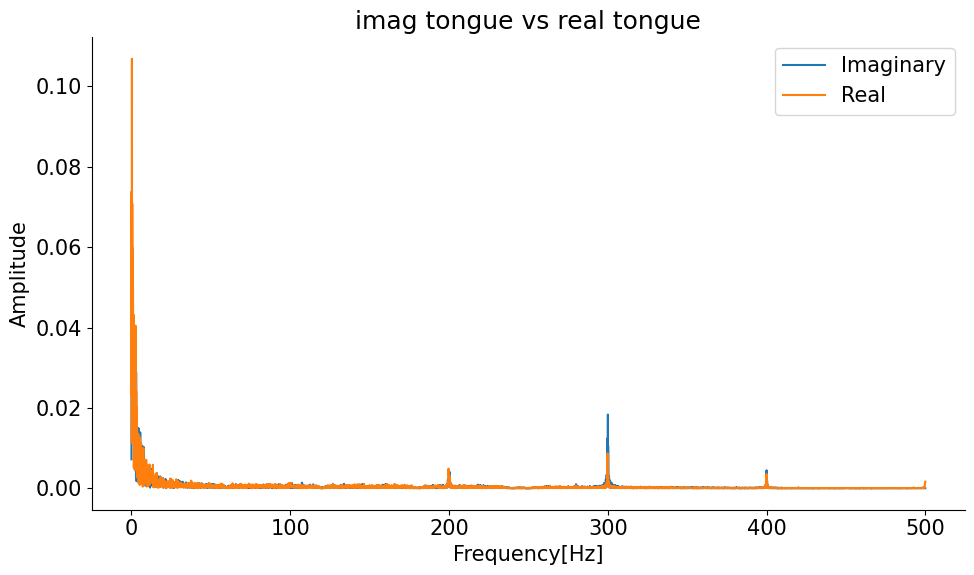

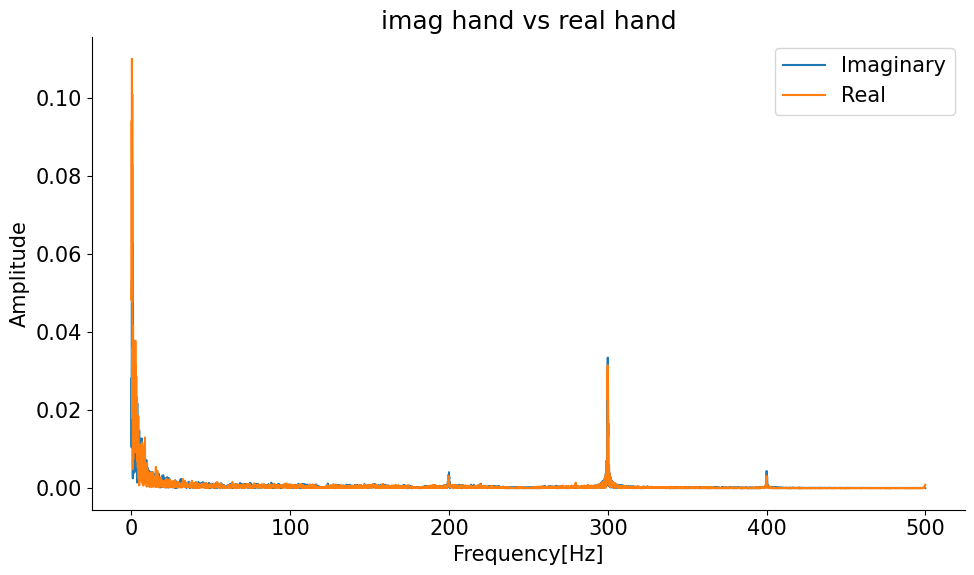

In [18]:
import numpy as np
from scipy.fft import fft, rfft
from scipy.fft import fftfreq, rfftfreq
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
%matplotlib inline

# For FB of hand movement data
fourier_real_hand = Fourier(V_hand_real, sampling_rate=1000)
fourier_imag_hand = Fourier(V_hand_imag, sampling_rate=1000)


# For FB of tongue movement data
fourier_real_tongue = Fourier(V_tongue_real, sampling_rate=1000)
fourier_imag_tongue = Fourier(V_tongue_imag, sampling_rate=1000)



Fourier.plot_two_spectral(name="real tongue vs imag tongue", fourier1 = fourier_real_tongue, fourier2=fourier_imag_tongue, low=8, high=100, interactive=True)
Fourier.plot_two_spectral(name="real hand vs imag hand", fourier1 = fourier_real_hand, fourier2= fourier_imag_hand, low=8, high=100, interactive=True)

Fourier.plot_two_spectral(name="imag tongue vs real tongue", fourier1 = fourier_imag_tongue , fourier2=fourier_real_tongue, interactive=False)
Fourier.plot_two_spectral(name="imag hand vs real hand", fourier1 = fourier_imag_hand, fourier2= fourier_real_hand, interactive=False)



<ipython-input-11-894ca511ae6c>:26: UserWarning:

Data has no positive values, and therefore cannot be log-scaled.



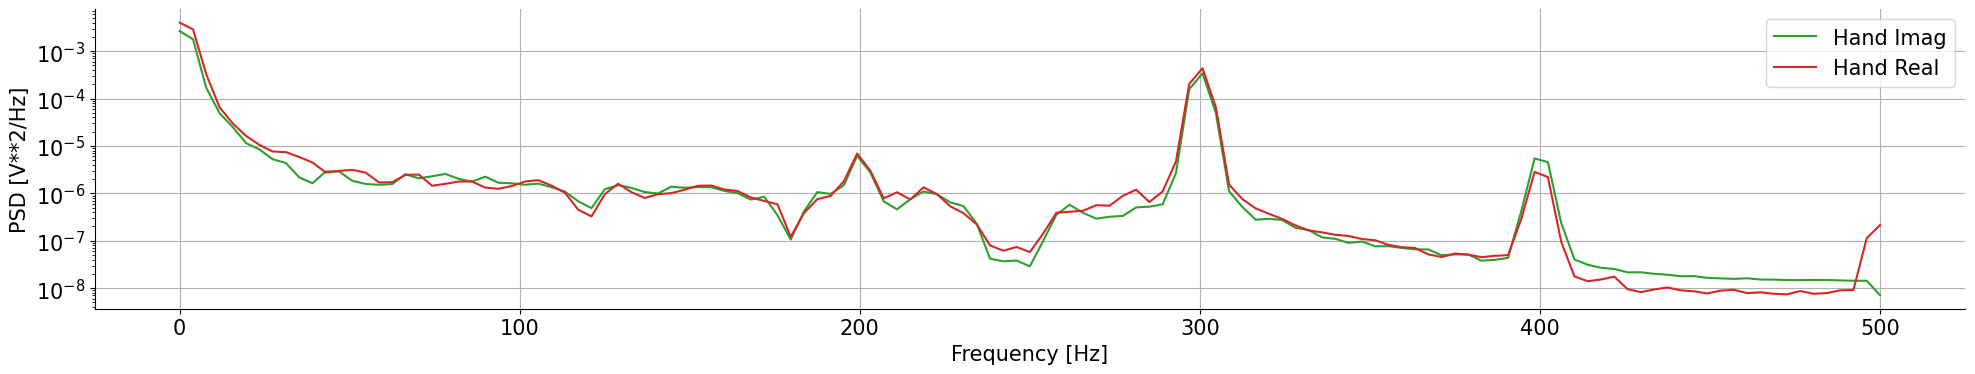

In [16]:
plot_psd(V_hand_imag, V_hand_real, fs=1000, low=0, high=500, label1='Hand Imag', label2='Hand Real')
plot_psd(V_tongue_imag, V_tongue_real, fs=1000, low=0, high=500, label1='Tongue Imag', label2='Tongue Real')

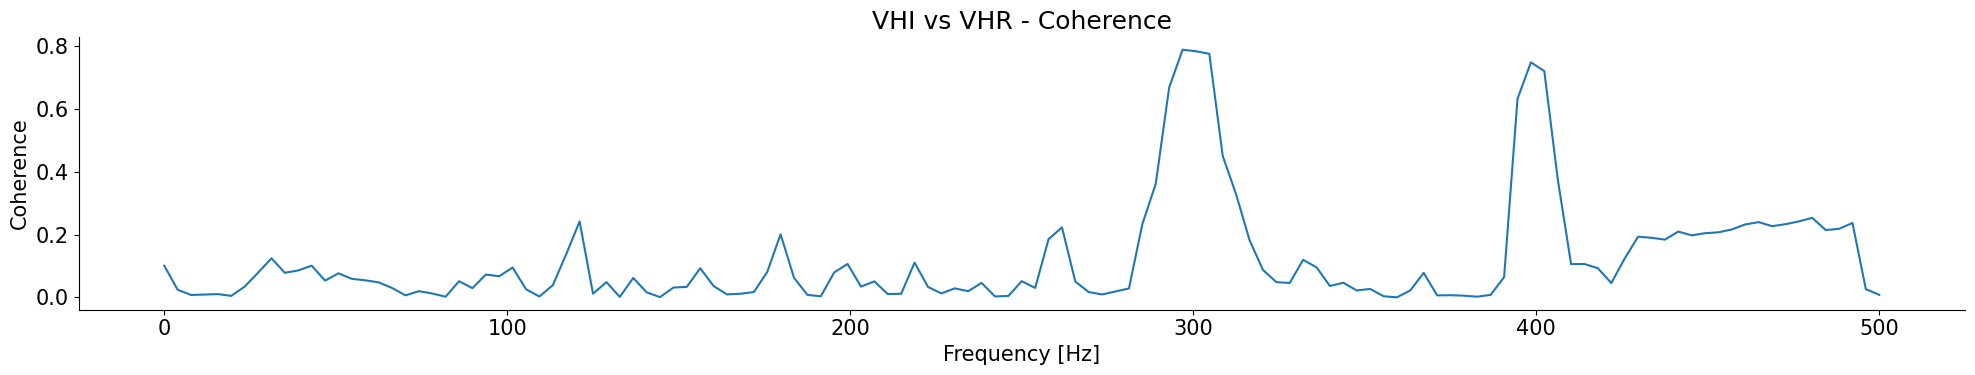

In [37]:
plot_coherence(name='Imag Hand vs Real Hand', fourier1=fourier_imag_hand, fourier2=fourier_real_hand, fs=1000, interactive=False)
plot_coherence(name='Imag Tongue vs Real Tongue', fourier1=fourier_imag_tongue, fourier2=fourier_real_tongue, fs=1000, interactive=False)


# Comparing Participants

In [46]:
person1 = 1
person2 = 2

In [51]:
# For FB of hand movement data
realp1 = Fourier(realset[0, person1], sampling_rate=1000)
imagp1 = Fourier(realset[1, person1], sampling_rate=1000)


# For FB of tongue movement data
realp2 = Fourier(realset[0, person2], sampling_rate=1000)
imagp2 = Fourier(realset[1, person2], sampling_rate=1000)

In [ ]:
plot_psd(realset[0, person1], realset[1, person1], fs=1000, low=0, high=500, label1='Real 1', label2='Real 2')
plot_psd(realset[0, person2], realset[1, person2], fs=1000, low=0, high=500, label1='Real 1', label2='Real 2')

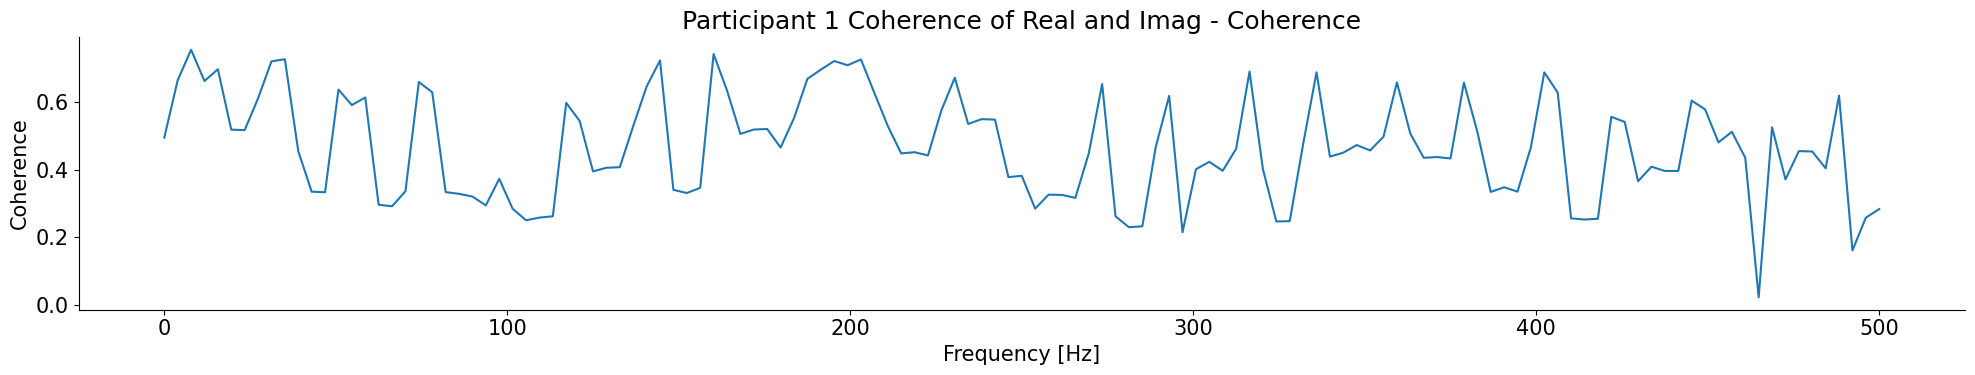

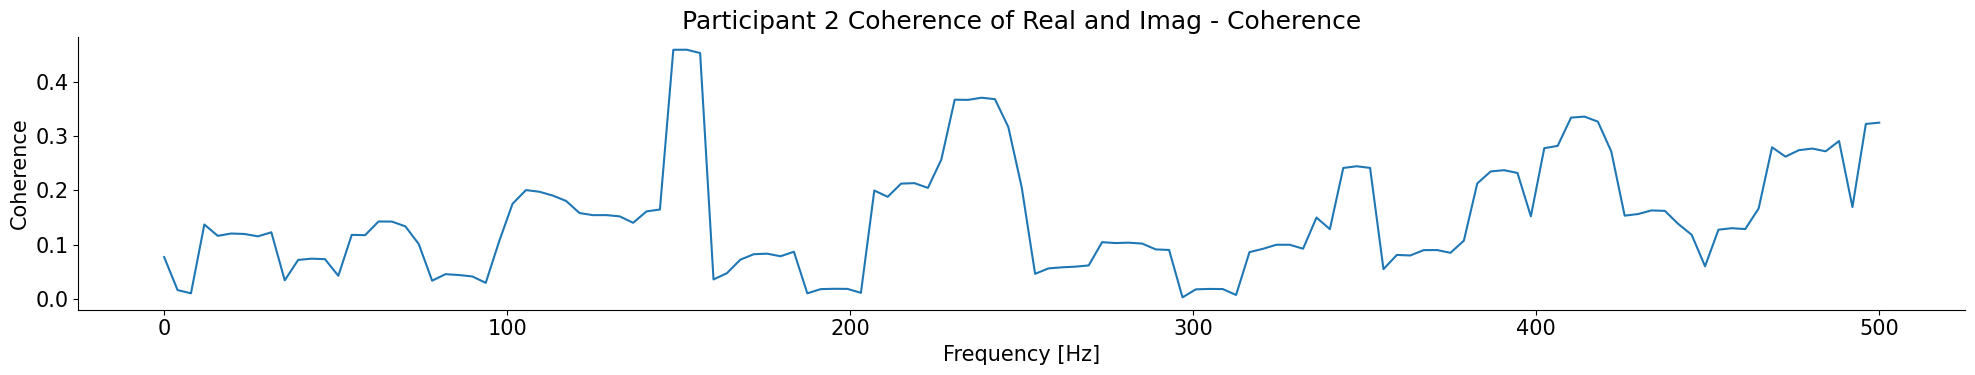

In [53]:
plot_coherence(name='Participant 1 Coherence of Real and Imag', fourier1=realp1, fourier2=imagp1, fs=1000, interactive=False)
plot_coherence(name='Participant 2 Coherence of Real and Imag', fourier1=realp2, fourier2=imagp2, fs=1000, interactive=False)